# Hackathon

Alexandros Pappas <br>
Aron Pap 

## Function definitions

In [1]:
# Import libraries
# Module imports
%matplotlib inline
import matplotlib.pylab as plt

from utils.helper_functions import *

import pandas as pd
import seaborn as sns
import numpy as np
import sklearn
import math
import copy
import pickle

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import auc, accuracy_score,recall_score,precision_score,f1_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVR



# Some base models
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection  import ParameterGrid
from sklearn import preprocessing
from sklearn.cluster import KMeans
import xgboost as xgb

import mlens
from mlens.visualization import corrmat
from mlens.ensemble import SuperLearner, BlendEnsemble, Subsemble, SequentialEnsemble

import pickle


# set seed
SEED=3642
np.random.seed(SEED)



from sklearn.metrics import mean_squared_error, r2_score
import fbprophet

[MLENS] backend: threading


# Read in and inspect data

In [2]:
def data_reading(path):
    """Reads in data, prints shape and head as well"""
    dataset = pd.read_csv(path)
    print("Shape of the dataset: {}".format(dataset.shape))
    print(dataset.head())
    
    print("Missing values per column")
    print(dataset.isnull().sum())
    
    print(dataset.describe())
    
    return dataset

In [3]:
# Test function
dataset = data_reading('./Data/train.csv')


/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3249: DtypeWarning:

Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.



Shape of the dataset: (1017209, 9)
   Store  DayOfWeek        Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5  2015-07-31   5263        555     1      1            0   
1      2          5  2015-07-31   6064        625     1      1            0   
2      3          5  2015-07-31   8314        821     1      1            0   
3      4          5  2015-07-31  13995       1498     1      1            0   
4      5          5  2015-07-31   4822        559     1      1            0   

   SchoolHoliday  
0              1  
1              1  
2              1  
3              1  
4              1  
Missing values per column
Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64
              Store     DayOfWeek         Sales     Customers          Open  \
count  1.017209e+06  1.017209e+06  1.017209e+06  1.017209e+06  1.017209e+06   
mean   5

In [4]:
# Filter dataset for a given store
dataset = dataset[dataset.Store==1023]

print(dataset.head())
print(dataset.shape)

      Store  DayOfWeek        Date  Sales  Customers  Open  Promo  \
1022   1023          5  2015-07-31   7182        649     1      1   
2137   1023          4  2015-07-30   6348        603     1      1   
3252   1023          3  2015-07-29   6010        544     1      1   
4367   1023          2  2015-07-28   6470        588     1      1   
5482   1023          1  2015-07-27   8230        701     1      1   

     StateHoliday  SchoolHoliday  
1022            0              1  
2137            0              1  
3252            0              1  
4367            0              1  
5482            0              1  
(942, 9)


# Exploratory Data Analysis

In [5]:
# Explanatory Data Analysis

def plot_time_series(dataset, target_var, date_var, time_period):
    temp = dataset[dataset[date_var]< time_period[1]]
    temp = temp[temp[date_var]> time_period[0]]
    
    plt.figure(figsize=(20,10))
    plt.plot(temp[date_var],temp[target_var])
    plt.show()

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


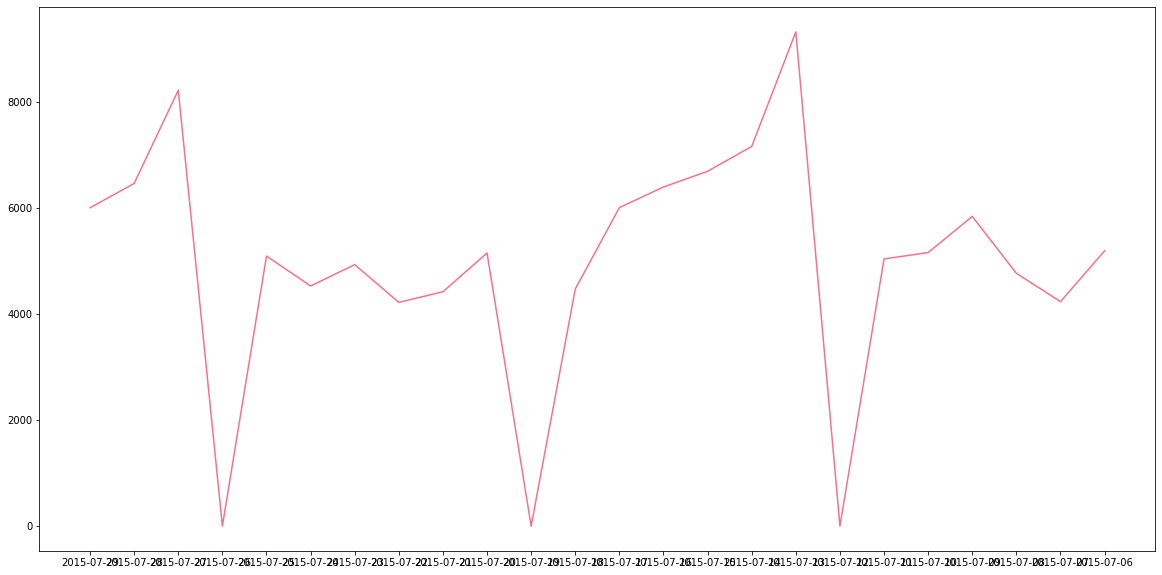

In [6]:
# Test
plot_time_series(dataset, 'Sales', 'Date', ['2015-07-05','2015-07-30'])

# Data preprocessing

## Missing data

In [7]:
# Function to handle missing data (separate for after lags as well!)

def missing_data_handle_before_lags(dataframe,threshold):
    """First drops columns with too many observations,
    then imputes mean for missing data if numerical,
    mode if categorical,
    assuming that we do not have missing values for the target, since supervised learning"""
    
    # Check dimensions of the dataset
    print("Dataset shape before dropping columns with too many missing values: {}".format(dataframe.shape))

    # Drop columns with more than 40% missing
    missing_threshold = threshold
    dataframe.dropna(axis=1,inplace=True,thresh=dataframe.shape[0]*(1-missing_threshold))
    print("Dataset shape after dropping columns with too many missing values: {}".format(dataframe.shape))

    Nulls= dataframe.isnull().sum()
    missing_data_col= dataframe.columns[Nulls>0]
    for i in missing_data_col:
        if dataframe[i].dtypes == 'int64' or dataframe[i].dtypes == 'float64':
            dataframe[i].fillna(dataframe[i].mean(),inplace=True)
        else:
            dataframe[i].fillna(dataframe[i].mode()[0],inplace=True)
    
    return dataframe

In [8]:
# Test
dataset = missing_data_handle_before_lags(dataset,0.5)
print(dataset.isnull().sum())

Dataset shape before dropping columns with too many missing values: (942, 9)
Dataset shape after dropping columns with too many missing values: (942, 9)
Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64


## Creating lag features

In [9]:
def lag_creators(num_lags,target_var,dataset):
    
    for i in range(1,num_lags+1):
        temp = 'lag_day_{}_{}'.format(i,target_var)
        dataset[temp] = dataset[target_var].shift(periods = -i)
        
    return dataset

In [10]:
dataset = lag_creators(4,'Sales',dataset)
print(dataset.head())

      Store  DayOfWeek        Date  Sales  Customers  Open  Promo  \
1022   1023          5  2015-07-31   7182        649     1      1   
2137   1023          4  2015-07-30   6348        603     1      1   
3252   1023          3  2015-07-29   6010        544     1      1   
4367   1023          2  2015-07-28   6470        588     1      1   
5482   1023          1  2015-07-27   8230        701     1      1   

     StateHoliday  SchoolHoliday  lag_day_1_Sales  lag_day_2_Sales  \
1022            0              1           6348.0           6010.0   
2137            0              1           6010.0           6470.0   
3252            0              1           6470.0           8230.0   
4367            0              1           8230.0              0.0   
5482            0              1              0.0           5098.0   

      lag_day_3_Sales  lag_day_4_Sales  
1022           6470.0           8230.0  
2137           8230.0              0.0  
3252              0.0           5098.0  


In [11]:
print(dataset.isnull().sum())

Store              0
DayOfWeek          0
Date               0
Sales              0
Customers          0
Open               0
Promo              0
StateHoliday       0
SchoolHoliday      0
lag_day_1_Sales    1
lag_day_2_Sales    2
lag_day_3_Sales    3
lag_day_4_Sales    4
dtype: int64


In [12]:
dataset = lag_creators(4,'Customers',dataset)
print(dataset.head())

      Store  DayOfWeek        Date  Sales  Customers  Open  Promo  \
1022   1023          5  2015-07-31   7182        649     1      1   
2137   1023          4  2015-07-30   6348        603     1      1   
3252   1023          3  2015-07-29   6010        544     1      1   
4367   1023          2  2015-07-28   6470        588     1      1   
5482   1023          1  2015-07-27   8230        701     1      1   

     StateHoliday  SchoolHoliday  lag_day_1_Sales  lag_day_2_Sales  \
1022            0              1           6348.0           6010.0   
2137            0              1           6010.0           6470.0   
3252            0              1           6470.0           8230.0   
4367            0              1           8230.0              0.0   
5482            0              1              0.0           5098.0   

      lag_day_3_Sales  lag_day_4_Sales  lag_day_1_Customers  \
1022           6470.0           8230.0                603.0   
2137           8230.0              0.0

## Missing data after lags

In [13]:
def missing_data_handler_after_lags(dataset):
    print("Shape of dataset before dropping rows: {}".format(dataset.shape))
    #df.drop(df.tail(n).index,inplace=True)
    dataset = dataset.dropna()
    print("Shape of dataset after dropping rows: {}".format(dataset.shape))
    print(dataset.isnull().sum())
    
    return dataset

In [14]:
# Test
dataset = missing_data_handler_after_lags(dataset)

Shape of dataset before dropping rows: (942, 17)
Shape of dataset after dropping rows: (938, 17)
Store                  0
DayOfWeek              0
Date                   0
Sales                  0
Customers              0
Open                   0
Promo                  0
StateHoliday           0
SchoolHoliday          0
lag_day_1_Sales        0
lag_day_2_Sales        0
lag_day_3_Sales        0
lag_day_4_Sales        0
lag_day_1_Customers    0
lag_day_2_Customers    0
lag_day_3_Customers    0
lag_day_4_Customers    0
dtype: int64


## Date features

In [15]:
def date_features(train_df,my_date_column):
    train_df['year'] = pd.to_datetime(train_df[my_date_column]).dt.year
    train_df['quarter'] = pd.to_datetime(train_df[my_date_column]).dt.quarter
    train_df['month'] = pd.to_datetime(train_df[my_date_column]).dt.month
    train_df['week'] = pd.to_datetime(train_df[my_date_column]).dt.week
    #train_df['day_of_year'] = pd.to_datetime(train_df[my_date_column]).dt.dayofyear
    train_df['day_of_month'] = pd.to_datetime(train_df[my_date_column]).dt.day
    
    
    return train_df

In [16]:
# Test
dataset = date_features(dataset,"Date")
print(dataset.head())

      Store  DayOfWeek        Date  Sales  Customers  Open  Promo  \
1022   1023          5  2015-07-31   7182        649     1      1   
2137   1023          4  2015-07-30   6348        603     1      1   
3252   1023          3  2015-07-29   6010        544     1      1   
4367   1023          2  2015-07-28   6470        588     1      1   
5482   1023          1  2015-07-27   8230        701     1      1   

     StateHoliday  SchoolHoliday  lag_day_1_Sales  ...  lag_day_4_Sales  \
1022            0              1           6348.0  ...           8230.0   
2137            0              1           6010.0  ...              0.0   
3252            0              1           6470.0  ...           5098.0   
4367            0              1           8230.0  ...           4534.0   
5482            0              1              0.0  ...           4937.0   

      lag_day_1_Customers  lag_day_2_Customers  lag_day_3_Customers  \
1022                603.0                544.0                5

## Creating dummy variables

In [17]:
# Define dummy columns


def dummy_creator(dataset,dummy_cols):
    
    # Generate dummy features for the categorical variables
    df_new = pd.get_dummies(dataset, prefix=dummy_cols,columns = dummy_cols,
                              drop_first = True,prefix_sep = '_dummy_')
    
    #df_new = df_new.drop(columns=dummy_cols)
    
    return df_new

In [18]:
# Test
dummy_cols = ['year','quarter','month','week','day_of_month','StateHoliday']
dataset = dummy_creator(dataset,dummy_cols)

print(dataset.head())

      Store  DayOfWeek        Date  Sales  Customers  Open  Promo  \
1022   1023          5  2015-07-31   7182        649     1      1   
2137   1023          4  2015-07-30   6348        603     1      1   
3252   1023          3  2015-07-29   6010        544     1      1   
4367   1023          2  2015-07-28   6470        588     1      1   
5482   1023          1  2015-07-27   8230        701     1      1   

      SchoolHoliday  lag_day_1_Sales  lag_day_2_Sales  ...  \
1022              1           6348.0           6010.0  ...   
2137              1           6010.0           6470.0  ...   
3252              1           6470.0           8230.0  ...   
4367              1           8230.0              0.0  ...   
5482              1              0.0           5098.0  ...   

      day_of_month_dummy_26  day_of_month_dummy_27  day_of_month_dummy_28  \
1022                      0                      0                      0   
2137                      0                      0        

## Drop unncecessary columns

In [19]:
def drop_unwanted_columns(df, drop_cols):
    for column in drop_cols:
        if column in df.columns:
            df.drop([column], axis=1, inplace=True)
            
    return df

In [20]:
# Test
unnecessary_col_list = ['Store','StateHoliday']

dataset = drop_unwanted_columns(dataset, unnecessary_col_list)

## Feature scaling

In [21]:
def rescale_df(df, scale_columns,path, scaler=None, pickle_file=True):
    # To avoid scaling the categorical columns, create a dataframe with
    # just the continuous variables
    scale_df = df[scale_columns]
    # This allows the scaler to be recycled for scaling test data
    if scaler is None:
        scaler = preprocessing.StandardScaler().fit(scale_df)
    scale_ndarray = scaler.transform(scale_df)
    df[scale_columns] = scale_ndarray
    if pickle_file:
        temp_path = path+'/scaler.sav'
        pickle.dump(scaler, open(temp_path, 'wb'))
    
    return df, scaler
    

In [22]:
scale_columns = [i for i in dataset.columns if "lag" in i]
scale_columns.append('Customers')

dataset, scaler = rescale_df(dataset, scale_columns,path = './Outputs', scaler=None, pickle_file=True)
dataset.describe()

,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,lag_day_1_Sales,lag_day_2_Sales,lag_day_3_Sales,lag_day_4_Sales,...,day_of_month_dummy_26,day_of_month_dummy_27,day_of_month_dummy_28,day_of_month_dummy_29,day_of_month_dummy_30,day_of_month_dummy_31,StateHoliday_dummy_0,StateHoliday_dummy_a,StateHoliday_dummy_b,StateHoliday_dummy_c
count,938.000000,938.000000,9.380000e+02,938.000000,938.000000,938.000000,9.380000e+02,9.380000e+02,9.380000e+02,9.380000e+02,...,938.000000,938.000000,938.000000,938.000000,938.000000,938.000000,938.000000,938.000000,938.000000,938.000000
mean,4.000000,5100.578891,-1.621541e-16,0.828358,0.383795,0.181237,9.572049e-17,6.595648e-17,-2.062361e-16,1.133895e-16,...,0.033049,0.033049,0.033049,0.029851,0.029851,0.019190,0.831557,0.021322,0.006397,0.004264
std,2.001067,2858.140287,1.000533e+00,0.377270,0.486568,0.385420,1.000533e+00,1.000533e+00,1.000533e+00,1.000533e+00,...,0.178860,0.178860,0.178860,0.170266,0.170266,0.137265,0.374459,0.144532,0.079765,0.065198
min,1.000000,0.000000,-1.932746e+00,0.000000,0.000000,0.000000,-1.785226e+00,-1.784799e+00,-1.784493e+00,-1.779284e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,4192.500000,-1.658095e-01,1.000000,0.000000,0.000000,-3.171653e-01,-3.165994e-01,-3.162155e-01,-3.150564e-01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,4.000000,5436.500000,2.164560e-01,1.000000,0.000000,0.000000,1.166873e-01,1.162436e-01,1.164753e-01,1.187046e-01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,6.000000,6613.000000,5.293028e-01,1.000000,1.000000,0.000000,5.292675e-01,5.299134e-01,5.303421e-01,5.319227e-01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,7.000000,15835.000000,3.624450e+00,1.000000,1.000000,1.000000,3.759614e+00,3.760565e+00,3.761164e+00,3.757681e+00,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Potential target transform

In [23]:
def target_log_transform(dataset,target_var):
    colname = "transformed_{}".format(target_var)
    dataset[colname] = np.log(dataset[target_var])
    # log of target etc
    
    return dataset

In [24]:
# Tests
dataset = target_log_transform(dataset,'Sales')
print(dataset.head())

      DayOfWeek        Date  Sales  Customers  Open  Promo  SchoolHoliday  \
1022          5  2015-07-31   7182   0.470066     1      1              1   
2137          4  2015-07-30   6348   0.299758     1      1              1   
3252          3  2015-07-29   6010   0.081321     1      1              1   
4367          2  2015-07-28   6470   0.244223     1      1              1   
5482          1  2015-07-27   8230   0.662587     1      1              1   

      lag_day_1_Sales  lag_day_2_Sales  lag_day_3_Sales  ...  \
1022         0.437612         0.319883         0.481399  ...   
2137         0.319257         0.480973         1.097778  ...   
3252         0.480332         1.097319        -1.784493  ...   
4367         1.096620        -1.784799         0.000904  ...   
5482        -1.785226         0.000504        -0.196617  ...   

      day_of_month_dummy_27  day_of_month_dummy_28  day_of_month_dummy_29  \
1022                      0                      0                      0  

/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning:

divide by zero encountered in log



## Data type transform if needed

In [25]:
dataset.dtypes

DayOfWeek                 int64
Date                     object
Sales                     int64
Customers               float64
Open                      int64
                         ...   
StateHoliday_dummy_0      uint8
StateHoliday_dummy_a      uint8
StateHoliday_dummy_b      uint8
StateHoliday_dummy_c      uint8
transformed_Sales       float64
Length: 117, dtype: object

In [26]:
def dtype_transform(dataset,col_list):
    for i in col_list:
        dataset[i] = dataset[i].astype('int32')
        
    return dataset
    

In [27]:
# Test
#X = dtype_transform(X,['StateHoliday'])

## Save preprocessed dataset (final modelling table)

In [28]:
def save_out_final_dataset(dataset,path):
    dataset.to_csv(path)
    

In [29]:
# Tests
save_out_final_dataset(dataset,'./Outputs/preprocessed_dataset.csv')

## Read in preprocessed dataset (final modelling table)

In [30]:
# Tests
dataset = data_reading('./Outputs/preprocessed_dataset.csv')

Shape of the dataset: (938, 118)
   Unnamed: 0  DayOfWeek        Date  Sales  Customers  Open  Promo  \
0        1022          5  2015-07-31   7182   0.470066     1      1   
1        2137          4  2015-07-30   6348   0.299758     1      1   
2        3252          3  2015-07-29   6010   0.081321     1      1   
3        4367          2  2015-07-28   6470   0.244223     1      1   
4        5482          1  2015-07-27   8230   0.662587     1      1   

   SchoolHoliday  lag_day_1_Sales  lag_day_2_Sales  ...  \
0              1         0.437612         0.319883  ...   
1              1         0.319257         0.480973  ...   
2              1         0.480332         1.097319  ...   
3              1         1.096620        -1.784799  ...   
4              1        -1.785226         0.000504  ...   

   day_of_month_dummy_27  day_of_month_dummy_28  day_of_month_dummy_29  \
0                      0                      0                      0   
1                      0             

## Sorting based on date

In [31]:
def date_sorting(dataset, date_col):
    dataset.sort_values(by=[date_col])
    
    return dataset

In [32]:
# Tests
dataset = date_sorting(dataset, 'Date')
print(dataset.head())

   Unnamed: 0  DayOfWeek        Date  Sales  Customers  Open  Promo  \
0        1022          5  2015-07-31   7182   0.470066     1      1   
1        2137          4  2015-07-30   6348   0.299758     1      1   
2        3252          3  2015-07-29   6010   0.081321     1      1   
3        4367          2  2015-07-28   6470   0.244223     1      1   
4        5482          1  2015-07-27   8230   0.662587     1      1   

   SchoolHoliday  lag_day_1_Sales  lag_day_2_Sales  ...  \
0              1         0.437612         0.319883  ...   
1              1         0.319257         0.480973  ...   
2              1         0.480332         1.097319  ...   
3              1         1.096620        -1.784799  ...   
4              1        -1.785226         0.000504  ...   

   day_of_month_dummy_27  day_of_month_dummy_28  day_of_month_dummy_29  \
0                      0                      0                      0   
1                      0                      0                      0

## Drop unnecessary columns again

In [33]:
# Drop unecessary cols
unnecessary_col_list = ['Unnamed: 0','Date','transformed_Sales']

dataset = drop_unwanted_columns(dataset, unnecessary_col_list)

## Feature-target split

In [34]:
def X_y_split(dataset, target_var):
    
    X = dataset.drop(columns = target_var)
    y = dataset[target_var]
    
    return X,y

In [35]:
# Tests
X,y = X_y_split(dataset, 'Sales')

## Sequential Train-validation split

In [36]:
# Function to create sequantial train-test split

def ts_split(X, y, valid_prop=0.1, sample_prop=None):
    """Function that does splits the data into validation and train
       assuming the most recent points are the validation set.
       Function will also sample the train set."""
    valid_num = int(X.shape[0]*valid_prop)
    X_valid = X[:valid_num]
    y_valid = y[:valid_num]
    train_num = y.shape[0] - valid_num
    if sample_prop is not None:
        train_num = int(train_num * sample_prop)
    X_train = X[valid_num:train_num + valid_num]
    y_train = y[valid_num:train_num + valid_num]
    
    return X_train, y_train, X_valid, y_valid

In [37]:
X_train, y_train, X_test, y_test = ts_split(X, y, valid_prop=0.2, sample_prop=None)

# Modelling

## Model definitions

In [38]:
# Define functions to be used
def get_models():
    #Generate a library of simple learners
    xgb1 = xgb.XGBRegressor(colsample_bytree= 0.7, learning_rate= 0.1, max_depth= 6,
                                  min_child_weight= 11, missing= -999, n_estimators= 70,
                                  nthread= 1, objective= 'reg:squarederror', reg_lambda= 5,
                                  seed= 1337, silent= 1, subsample= 0.8)
    knn = KNeighborsRegressor(n_neighbors=3)
    lr = LinearRegression()
    rf = RandomForestRegressor(n_estimators=10, max_features=3, random_state=SEED)
    svr = SVR(kernel='linear',epsilon=0.2)

    models = {'xgb': xgb1,
              'knn': knn,
              'random forest': rf,
              'linear': lr,
              'SVM': svr
              }

    return models


def train_predict(model_list,xtrain=X_train,ytrain=y_train,xtest=X_test,ytest=y_test):
    #Fit models in list on training set and return preds
    P = np.zeros((ytest.shape[0], len(model_list)))
    P = pd.DataFrame(P)

    cols = list()
    for i, (name, m) in enumerate(models.items()):
        print("%s..." % name, end=" ", flush=False)
        m.fit(xtrain, ytrain)
        #P.iloc[:, i] = m.predict_proba(xtest)[:, 1]
        #P.iloc[:, i] = m.predict(xtest)[:, 1]
        P.iloc[:, i] = m.predict(xtest)
        cols.append(name)
        print("done")

    P.columns = cols
    print("Done.\n")
    return P


def score_models(P, y):
    # Score model in test set
    print("Scoring models.")
    mse_scores=[]
    r2_scores=[]
    for m in P.columns:
        score = mean_squared_error(y, P.loc[:, m])
        mse_scores.append(score)
        
        r2_score_temp = r2_score(y, P.loc[:, m])
        r2_scores.append(r2_score_temp)
        
        print("%-26s: %.3f" % (m, score))
    return P.columns,mse_scores, r2_scores

In [39]:
## 

In [40]:
# Tests
# Run base-learner models

models = get_models()
P = train_predict(models,X_train,y_train,X_test,y_test)
my_models,mse_scores,r2_scores = score_models(P, y_test)

xgb... 

/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



done
knn... done
random forest... done
linear... done
SVM... done
Done.

Scoring models.
xgb                       : 120892.236
knn                       : 496691.583
random forest             : 1152619.235
linear                    : 103484.932
SVM                       : 3486006.193


In [41]:
# Tests
r2_scores

[0.9811694218955886,
 0.9226336616622066,
 0.8204641821200789,
 0.9838808416241385,
 0.4570080437369304]

## Gridsearch

In [61]:
def gridsearch(model,parameters,X,y,param_string):
    
    # Run gridsearch
    regr = GridSearchCV(model, parameters, n_jobs=3, 
                   cv=5,
                   scoring='neg_mean_squared_error',
                   verbose=2, refit=True)



    # Fit the model
    regr.fit(X, y)
    
    # Check the results of gridsearch
    GridSearch_table_plot(regr,param_string, negative=False, display_all_params=False)
    
    return regr

### XGBOOST

Fitting 5 folds for each of 162 candidates, totalling 810 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:    6.5s
[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed:   22.6s
[Parallel(n_jobs=3)]: Done 359 tasks      | elapsed:   57.7s
[Parallel(n_jobs=3)]: Done 642 tasks      | elapsed:  1.7min
[Parallel(n_jobs=3)]: Done 810 out of 810 | elapsed:  2.3min finished
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.



best parameters: {'colsample_bytree': 0.7, 'eval_metric': 'rmse', 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 11, 'missing': -999, 'n_estimators': 70, 'nthread': 1, 'objective': 'reg:squarederror', 'reg_alpha': 5, 'reg_lambda': 2, 'seed': 1337, 'silent': 1, 'subsample': 0.8}
best score:      -166836.61351 (+/-98881.28069)


,param_colsample_bytree,param_eval_metric,param_learning_rate,param_max_depth,param_min_child_weight,param_missing,param_n_estimators,param_nthread,param_objective,param_reg_alpha,...,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
106,0.7,rmse,0.1,4,11,-999,70,1,reg:squarederror,5,...,0.8,"{'colsample_bytree': 0.7, 'eval_metric': 'rmse...",-116366.541812,-135796.375118,-76843.055010,-359132.569309,-146961.659274,-166836.613507,98881.280690,1
103,0.7,rmse,0.1,4,11,-999,70,1,reg:squarederror,2,...,0.8,"{'colsample_bytree': 0.7, 'eval_metric': 'rmse...",-117320.032338,-135787.757297,-76828.499222,-359086.915205,-147412.131329,-167103.778259,98751.867923,2
100,0.7,rmse,0.1,4,11,-999,70,1,reg:squarederror,0.5,...,0.8,"{'colsample_bytree': 0.7, 'eval_metric': 'rmse...",-117318.495200,-135752.026763,-76825.856151,-359064.226293,-147719.246904,-167152.482487,98733.859285,3
126,0.7,rmse,0.1,6,11,-999,70,1,reg:squarederror,0.5,...,0.8,"{'colsample_bytree': 0.7, 'eval_metric': 'rmse...",-109184.024459,-137640.111064,-83723.970153,-366269.668174,-148535.793661,-168882.372314,101061.229407,4
160,0.7,rmse,0.1,8,11,-999,70,1,reg:squarederror,5,...,0.8,"{'colsample_bytree': 0.7, 'eval_metric': 'rmse...",-114909.670832,-142387.303655,-78151.214159,-360376.379188,-150002.966516,-168982.086474,98772.830664,5
132,0.7,rmse,0.1,6,11,-999,70,1,reg:squarederror,5,...,0.8,"{'colsample_bytree': 0.7, 'eval_metric': 'rmse...",-106439.993550,-140630.065184,-80645.322208,-371620.785511,-147617.548888,-169198.358368,103856.910362,6
129,0.7,rmse,0.1,6,11,-999,70,1,reg:squarederror,2,...,0.8,"{'colsample_bytree': 0.7, 'eval_metric': 'rmse...",-109060.802768,-134527.083787,-80926.857463,-373129.772037,-150272.346667,-169386.959566,104354.444059,7
159,0.7,rmse,0.1,8,11,-999,70,1,reg:squarederror,5,...,0.8,"{'colsample_bytree': 0.7, 'eval_metric': 'rmse...",-109299.440571,-135058.142033,-88352.743972,-368040.443513,-147235.548404,-169409.543587,101198.654930,8
153,0.7,rmse,0.1,8,11,-999,70,1,reg:squarederror,0.5,...,0.8,"{'colsample_bytree': 0.7, 'eval_metric': 'rmse...",-107609.576570,-135985.810776,-86284.088405,-369183.265842,-149522.843960,-169525.995708,102026.984090,9
130,0.7,rmse,0.1,6,11,-999,70,1,reg:squarederror,2,...,0.8,"{'colsample_bytree': 0.7, 'eval_metric': 'rmse...",-114223.319991,-143915.777611,-76109.649671,-363334.413982,-153079.106317,-169944.661816,100177.579889,10


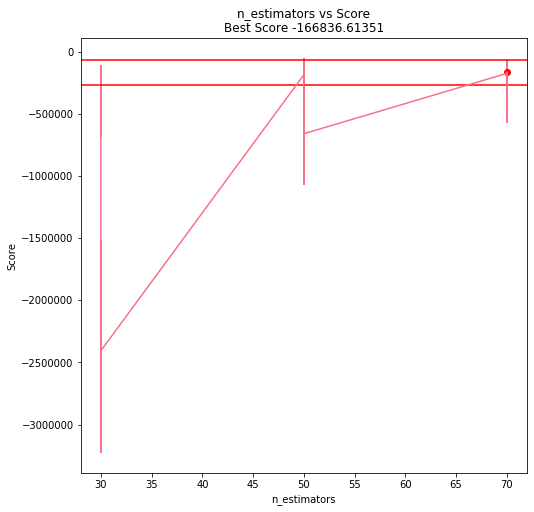

In [49]:
# Tests
# Initialize model
xgb_model_grid = xgb.XGBRegressor()

# Set parameters for gridsearch
parameters = {'nthread':[1], #when use hyperthread, xgboost may become slower
              'objective':['reg:squarederror'],
              'eval_metric':['rmse'],
              'learning_rate': [0.05,0.1], #so called `eta` value
              'max_depth': [4,6,8],
              'min_child_weight': [11],
              'silent': [1],
              'subsample': [0.8],
              'colsample_bytree': [0.7],
              'n_estimators': [30,50,70], #number of trees 
              'missing':[-999],
              'reg_lambda':[0.5,2,5],
              'reg_alpha':[0.5,2,5],
              'seed': [1337]}

xgb_model = gridsearch(xgb_model_grid,parameters,X,y,"n_estimators")

### Random Forest

In [48]:
# Tests
# Initialize model
randomforest_grid = RandomForestRegressor()

# Set parameters for gridsearch
parameters = {'bootstrap':[True,False],
              #'class_weight':[None],
              #'criterion'=['gini',''],
                'max_depth':[30,50,70],
              'max_features':[3, 10, 20],
              'max_leaf_nodes':[None,10,5],
                'min_samples_leaf':[50,100,200],
              'min_samples_split':[2,4,6],
                'n_estimators':[10,50,90],
                'n_jobs':[3],
              'oob_score':[True],
              'random_state':[3642],
                'verbose':[0],
              'warm_start':[False]}

randomforest_model = gridsearch(randomforest_grid,parameters,X,y,"n_estimators")

Fitting 5 folds for each of 1458 candidates, totalling 7290 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:    6.6s
[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed:   19.6s


KeyboardInterrupt: 

### SVM

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  64 tasks      | elapsed:    3.3s
[Parallel(n_jobs=3)]: Done  80 out of  80 | elapsed:    4.1s finished
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.



best parameters: {'C': 20, 'epsilon': 5, 'kernel': 'linear'}
best score:      -207030.74256 (+/-79379.31264)


,param_C,param_epsilon,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
12,20,5,linear,"{'C': 20, 'epsilon': 5, 'kernel': 'linear'}",-1.733870e+05,-2.854694e+05,-1.645764e+05,-3.118452e+05,-9.986318e+04,-2.070307e+05,7.937931e+04,1
8,20,0.5,linear,"{'C': 20, 'epsilon': 0.5, 'kernel': 'linear'}",-1.709583e+05,-2.893526e+05,-1.644840e+05,-3.137176e+05,-9.963696e+04,-2.076319e+05,8.093186e+04,2
4,1,5,linear,"{'C': 1, 'epsilon': 5, 'kernel': 'linear'}",-3.554732e+06,-4.705614e+06,-3.860743e+06,-5.808962e+06,-3.998610e+06,-4.384628e+06,8.048925e+05,3
0,1,0.5,linear,"{'C': 1, 'epsilon': 0.5, 'kernel': 'linear'}",-3.559424e+06,-4.706055e+06,-3.859640e+06,-5.809154e+06,-4.000354e+06,-4.385821e+06,8.040050e+05,4
9,20,0.5,rbf,"{'C': 20, 'epsilon': 0.5, 'kernel': 'rbf'}",-5.875972e+06,-7.601260e+06,-6.312898e+06,-9.206345e+06,-6.448353e+06,-7.087391e+06,1.201589e+06,5
13,20,5,rbf,"{'C': 20, 'epsilon': 5, 'kernel': 'rbf'}",-5.875850e+06,-7.600996e+06,-6.312898e+06,-9.207618e+06,-6.448304e+06,-7.087558e+06,1.202043e+06,6
11,20,0.5,sigmoid,"{'C': 20, 'epsilon': 0.5, 'kernel': 'sigmoid'}",-6.257141e+06,-7.984878e+06,-6.685795e+06,-9.607925e+06,-6.835741e+06,-7.472702e+06,1.209395e+06,7
15,20,5,sigmoid,"{'C': 20, 'epsilon': 5, 'kernel': 'sigmoid'}",-6.262159e+06,-7.984637e+06,-6.691638e+06,-9.608979e+06,-6.836500e+06,-7.475192e+06,1.207895e+06,8
14,20,5,poly,"{'C': 20, 'epsilon': 5, 'kernel': 'poly'}",-6.756481e+06,-8.609747e+06,-7.187051e+06,-1.034069e+07,-7.338467e+06,-8.044796e+06,1.301691e+06,9
10,20,0.5,poly,"{'C': 20, 'epsilon': 0.5, 'kernel': 'poly'}",-6.756612e+06,-8.610611e+06,-7.187099e+06,-1.033948e+07,-7.338905e+06,-8.044851e+06,1.301262e+06,10


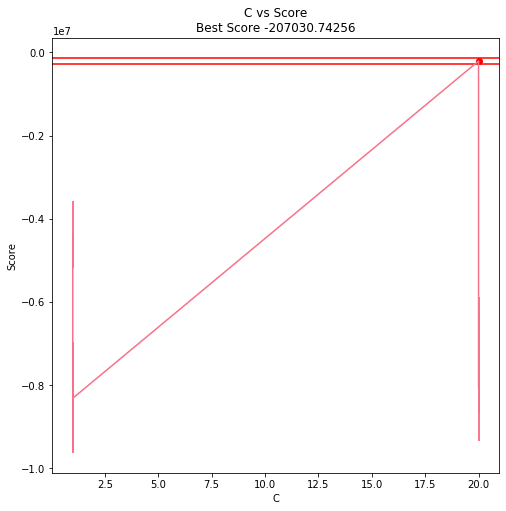

In [62]:
# Inititalize SVR model
SVR_model = SVR()

# Define the grid for searching
svm_params = {'C':[1,20],
               'epsilon':[0.5,5],'kernel':['linear','rbf','poly','sigmoid']}

svm_model = gridsearch(SVR_model,svm_params,X,y,"C")

### K-NN

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


best parameters: {'metric': 'minkowski', 'n_neighbors': 5, 'weights': 'distance'}
best score:      -943491.35915 (+/-483404.65547)


[Parallel(n_jobs=3)]: Done 120 out of 120 | elapsed:    2.0s finished
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.



,param_metric,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
15,minkowski,5,distance,"{'metric': 'minkowski', 'n_neighbors': 5, 'wei...",-473338.625545,-1.132562e+06,-597974.043888,-1.804152e+06,-7.127807e+05,-9.434914e+05,483404.655470,1
14,minkowski,5,uniform,"{'metric': 'minkowski', 'n_neighbors': 5, 'wei...",-495194.074043,-1.206967e+06,-644132.758511,-1.986768e+06,-7.493899e+05,-1.015741e+06,539847.019733,2
3,manhattan,5,distance,"{'metric': 'manhattan', 'n_neighbors': 5, 'wei...",-624527.924789,-1.157120e+06,-602562.310700,-1.975321e+06,-7.897311e+05,-1.029101e+06,512320.012695,3
17,minkowski,10,distance,"{'metric': 'minkowski', 'n_neighbors': 10, 'we...",-595868.763835,-1.216093e+06,-650440.445646,-1.995801e+06,-7.646363e+05,-1.043852e+06,522871.186192,4
2,manhattan,5,uniform,"{'metric': 'manhattan', 'n_neighbors': 5, 'wei...",-668243.084255,-1.263865e+06,-643544.358085,-2.175369e+06,-8.412619e+05,-1.117625e+06,572785.125713,5
5,manhattan,10,distance,"{'metric': 'manhattan', 'n_neighbors': 10, 'we...",-739850.797067,-1.343849e+06,-679658.753841,-2.043521e+06,-8.308166e+05,-1.126879e+06,514322.323667,6
16,minkowski,10,uniform,"{'metric': 'minkowski', 'n_neighbors': 10, 'we...",-643036.061064,-1.310509e+06,-703345.286755,-2.170257e+06,-8.153978e+05,-1.127732e+06,570967.904301,7
4,manhattan,10,uniform,"{'metric': 'manhattan', 'n_neighbors': 10, 'we...",-831178.716277,-1.516834e+06,-763289.394415,-2.240433e+06,-9.161043e+05,-1.252876e+06,560970.380055,8
19,minkowski,20,distance,"{'metric': 'minkowski', 'n_neighbors': 20, 'we...",-663807.636063,-1.532711e+06,-814290.366562,-2.420623e+06,-9.244826e+05,-1.270327e+06,645635.933321,9
12,minkowski,1,uniform,"{'metric': 'minkowski', 'n_neighbors': 1, 'wei...",-824136.670213,-1.962827e+06,-673001.484043,-1.971715e+06,-1.040682e+06,-1.294021e+06,561743.922445,10


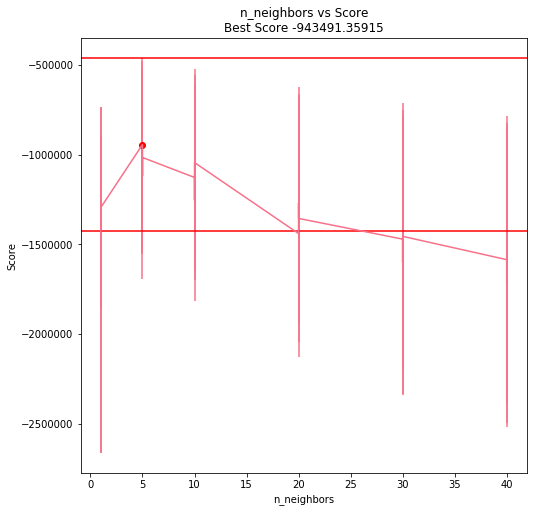

In [63]:
# Initialize K-NN model 
MyKNN = KNeighborsRegressor(algorithm='auto')

# Define grid values for the parameters
knn_grid_values = {'n_neighbors':[1, 5, 10,20,30,40],'weights':['uniform','distance'],
               'metric':['manhattan','minkowski']}

knn_model = gridsearch(MyKNN,knn_grid_values,X,y,"n_neighbors")

## Ensembles

In [64]:
def ensembles(X_train, y_train,X_test, y_test,propagation_bool,prop_features,SEED):
    # Building ensemble model
    #meta_learner3 = GradientBoostingRegressor(
    meta_learner3 = RandomForestRegressor(
        n_estimators=70,
        #bootstrap=True,
        max_features=0.7,
        random_state=SEED)


    # Select features to propagate
    if propagation_bool:
        to_propagate2=prop_features # you can add the most important according to random forest, for example
        pointer2= [i for i,x in enumerate(X_train.columns) if x in to_propagate2]
        print(X_train.columns[pointer2])

    s3 = SuperLearner(
        folds=5,
        random_state=SEED,
        verbose=2,
        backend="multiprocessing",
        n_jobs=3
    )

    # Add the base learners and the meta learner
    s3.add(list(models.values()))
    s3.add_meta(meta_learner3)

    # Train the ensemble
    s3.fit(X_train, y_train)
    
    
    # Predict the test set
    p_s3 = s3.predict(X_test)
    #print(p_s3)
    score_r2=r2_score(y_test, p_s3)
    print("\nSuper Learner R^2 score: %.3f" % score_r2)

    score_mse=mean_squared_error(y_test, p_s3)
    print("\nSuper Learner MSE score: %.3f" % score_mse)
    
    return s3

In [65]:
ensemble_model = ensembles(X_train, y_train,
                           X_test, y_test,propagation_bool=True,
                           prop_features=['Customers','Open'],SEED=42)

Index(['Customers', 'Open'], dtype='object')

Fitting 2 layers
Processing layer-1             

/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version

/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



done | 00:00:02
Processing layer-2             done | 00:00:00
Fit complete                        | 00:00:03

Predicting 2 layers
Processing layer-1             done | 00:00:00
Processing layer-2             done | 00:00:00
Predict complete                    | 00:00:00

Super Learner R^2 score: 0.983

Super Learner MSE score: 110672.729


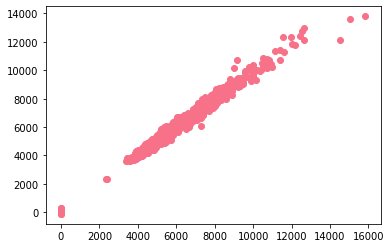

In [66]:
# Compare predictions vs true values
y_pred_train = regr_model.predict(X)

# Plot actual vs predicted
plt.scatter(y,y_pred_train)
plt.show()

### Feature importance

In [67]:
def feature_importance(X,y,gridsearch_cv_model):
    
    # Refit model with the best parameters
    model = gridsearch_cv_model.best_estimator_

    # Fit the model
    model.fit(X, y)

    feature_names = X.columns
    importance = model.feature_importances_
    important_features = pd.Series(data=importance/importance.max() ,index=feature_names)
    important_features = important_features.sort_values(ascending=False)
    
    # Visualize importance

    plt.figure(figsize=(25,5))
    plt.bar(range(10), height = important_features[0:10])
    plt.xticks(ticks = np.arange(0, 10,1),labels = important_features.index[0:10])
    plt.title("Relative importance of the 10 most important feature")
    plt.show()
    
    return model

/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



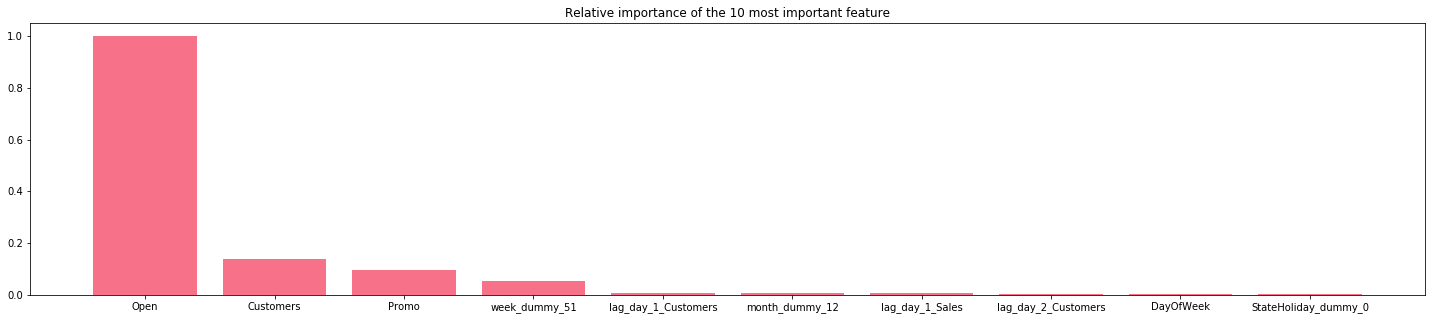

In [68]:
# Tests
final_model = feature_importance(X,y,regr_model)

In [71]:
# Dump/Pickle
def dump_objects(path,object_to_pickle):
    filename = path
    pickle.dump(object_to_pickle, open(filename, 'wb'))

In [72]:
# Tests
dump_objects('./Outputs/final_model.sav',final_model)

In [73]:
dump_objects('./Outputs/final_model_columns.sav',X.columns)

In [74]:
dump_objects('./Outputs/ensemble_model.sav',ensemble_model)

In [75]:
dump_objects('./Outputs/single_model.sav',regr_model)

Shape of the dataset: (41088, 8)
   Id  Store  DayOfWeek        Date  Open  Promo StateHoliday  SchoolHoliday
0   1      1          4  2015-09-17   1.0      1            0              0
1   2      3          4  2015-09-17   1.0      1            0              0
2   3      7          4  2015-09-17   1.0      1            0              0
3   4      8          4  2015-09-17   1.0      1            0              0
4   5      9          4  2015-09-17   1.0      1            0              0
Missing values per column
Id                0
Store             0
DayOfWeek         0
Date              0
Open             11
Promo             0
StateHoliday      0
SchoolHoliday     0
dtype: int64
                 Id         Store     DayOfWeek          Open         Promo  \
count  41088.000000  41088.000000  41088.000000  41077.000000  41088.000000   
mean   20544.500000    555.899533      3.979167      0.854322      0.395833   
std    11861.228267    320.274496      2.015481      0.352787      0.

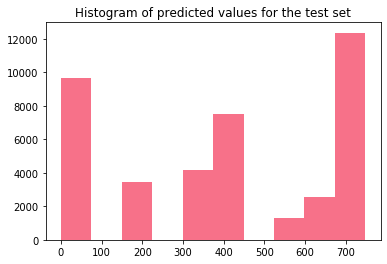

         Date Predicted_value
0  2015-09-17           722.2
1  2015-09-17           722.2
2  2015-09-17           722.2
3  2015-09-17           722.2
4  2015-09-17           722.2


In [77]:
# Read-in test data
test = data_reading('./Data/test.csv')

# Save the dates from the test set for the submission files
dates = test['Date']
# Handle missing values before lags
test = missing_data_handle_before_lags(test,0.5)
#print(test.isnull().sum())

# Generate lags
#test = lag_creators(4,'Sales',test)
#test = lag_creators(4,'Customers',test)


# Handle missing data after lags
test = missing_data_handler_after_lags(test)

# Test
test = date_features(test,"Date")
#print(test.head())

# Test
dummy_cols = ['year','quarter','month','week','day_of_month','StateHoliday']
test = dummy_creator(test,dummy_cols)

#print(dataset.head())

# Drop unnecessary columns
unnecessary_col_list = ['Store','Id']
test = drop_unwanted_columns(test, unnecessary_col_list)

# Scale columns
#scale_columns = [i for i in dataset.columns if "lag" in i]
#scale_columns.append('Customers')

# Import scaler
filename = './Outputs/scaler.sav'
sc = pickle.load(open(filename, 'rb'))

# Import columns from the final model
filename = './Outputs/final_model_columns.sav'
final_model_columns = pickle.load(open(filename, 'rb'))

# Add columns which are missing from validation set, but were in the train set
colnames = test.columns
for i in final_model_columns:
        if i not in colnames:
            test[i]=0
            
# Drop columns which are in the validation set, but not in the train set
for j in colnames:
        if j not in final_model_columns:
            test = test.drop(columns=j)
            
# Rearrange columns
test = test[final_model_columns]

test, scaler = rescale_df(test, scale_columns,path = './Outputs', scaler=sc, pickle_file=False)
print(test.describe())

# Import best ensemble model
filename = './Outputs/ensemble_model.sav'
ensemble_model = pickle.load(open(filename, 'rb'))

# Import best single model
filename = './Outputs/single_model.sav'
single_model = pickle.load(open(filename, 'rb'))

# Import best single model

# Predict results
test_pred = ensemble_model.predict(test)
print(test_pred.shape)
plt.hist(test_pred)
plt.title("Histogram of predicted values for the test set")
plt.show()

# Display some performance metrics
#print("Validation: MSE of the model: {}".format(mean_squared_error(y, y_pred)))

# Get correlation for the validation set
#y = pd.Series(y)
#y_pred = pd.Series(y_pred)
#temp_corr = y.corr(y_pred)

#print("Validation: R^2 of the model: {}".format(temp_corr))

# Generate dataframe for submission
submission = np.array((dates,test_pred))
submission  = pd.DataFrame(submission.T)
submission.columns = ['Date','Predicted_value']
print(submission.head())

# Save out prediction/submission file
save_out_final_dataset(submission,'./Outputs/predictions.csv')



In [78]:
def validation(path):
    test = data_reading(path)

    # Save the dates from the test set for the submission files
    dates = test['Date']
    # Handle missing values before lags
    test = missing_data_handle_before_lags(test,0.5)
    #print(test.isnull().sum())

    # Generate lags
    #test = lag_creators(4,'Sales',test)
    #test = lag_creators(4,'Customers',test)


    # Handle missing data after lags
    test = missing_data_handler_after_lags(test)

    # Test
    test = date_features(test,"Date")
    #print(test.head())

    # Test
    dummy_cols = ['year','quarter','month','week','day_of_month','StateHoliday']
    test = dummy_creator(test,dummy_cols)

    #print(dataset.head())

    # Drop unnecessary columns
    unnecessary_col_list = ['Store','Id']
    test = drop_unwanted_columns(test, unnecessary_col_list)

    # Scale columns
    #scale_columns = [i for i in dataset.columns if "lag" in i]
    #scale_columns.append('Customers')

    # Import scaler
    filename = './Outputs/scaler.sav'
    sc = pickle.load(open(filename, 'rb'))

    # Import columns from the final model
    filename = './Outputs/final_model_columns.sav'
    final_model_columns = pickle.load(open(filename, 'rb'))

    # Add columns which are missing from validation set, but were in the train set
    colnames = test.columns
    for i in final_model_columns:
            if i not in colnames:
                test[i]=0

    # Drop columns which are in the validation set, but not in the train set
    for j in colnames:
            if j not in final_model_columns:
                test = test.drop(columns=j)

    # Rearrange columns
    test = test[final_model_columns]

    test, scaler = rescale_df(test, scale_columns,path = './Outputs', scaler=sc, pickle_file=False)
    print(test.describe())

    # Import best ensemble model
    filename = './Outputs/ensemble_model.sav'
    ensemble_model = pickle.load(open(filename, 'rb'))

    # Import best single model
    filename = './Outputs/single_model.sav'
    single_model = pickle.load(open(filename, 'rb'))

    # Import best single model

    # Predict results
    test_pred = ensemble_model.predict(test)
    print(test_pred.shape)
    plt.hist(test_pred)
    plt.title("Histogram of predicted values for the test set")
    plt.show()

    # Display some performance metrics
    #print("Validation: MSE of the model: {}".format(mean_squared_error(y, y_pred)))

    # Get correlation for the validation set
    #y = pd.Series(y)
    #y_pred = pd.Series(y_pred)
    #temp_corr = y.corr(y_pred)

    #print("Validation: R^2 of the model: {}".format(temp_corr))

    # Generate dataframe for submission
    submission = np.array((dates,test_pred))
    submission  = pd.DataFrame(submission.T)
    submission.columns = ['Date','Predicted_value']
    print(submission.head())

    # Save out prediction/submission file
    save_out_final_dataset(submission,'./Outputs/predictions.csv')

Shape of the dataset: (41088, 8)
   Id  Store  DayOfWeek        Date  Open  Promo StateHoliday  SchoolHoliday
0   1      1          4  2015-09-17   1.0      1            0              0
1   2      3          4  2015-09-17   1.0      1            0              0
2   3      7          4  2015-09-17   1.0      1            0              0
3   4      8          4  2015-09-17   1.0      1            0              0
4   5      9          4  2015-09-17   1.0      1            0              0
Missing values per column
Id                0
Store             0
DayOfWeek         0
Date              0
Open             11
Promo             0
StateHoliday      0
SchoolHoliday     0
dtype: int64
                 Id         Store     DayOfWeek          Open         Promo  \
count  41088.000000  41088.000000  41088.000000  41077.000000  41088.000000   
mean   20544.500000    555.899533      3.979167      0.854322      0.395833   
std    11861.228267    320.274496      2.015481      0.352787      0.

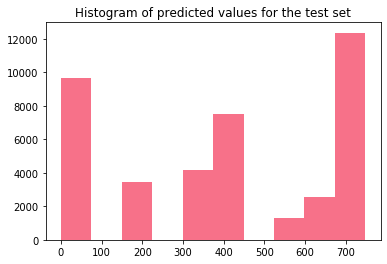

         Date Predicted_value
0  2015-09-17           722.2
1  2015-09-17           722.2
2  2015-09-17           722.2
3  2015-09-17           722.2
4  2015-09-17           722.2


In [86]:
# Test validation function
validation(path='./Data/test.csv')

In [ ]:
# 1 Trying out different models on the different computers
# 2 Giving the best models to the Ensemble
# CATEGORY ENCODER?? - https://contrib.scikit-learn.org/categorical-encoding/
# FB Prophet?? from fbprophet import Prophet

In [76]:
# Saving output files

def save_out(model):
    pass

In [69]:
# Function to score model

def scoring_func(metric,time_period,X,y):
    pass

In [18]:
def model_comparison():
    pass

In [20]:
def sampling(X):
    pass

In [56]:
def get_outside_data():
    pass

## Other functions

In [146]:
def check_for_missing_data(df, threshold=0.4, drop_nas=False, drop_columns=False):
    null_list = list()
    for column in df.columns:
        null_count = df[column].isnull().sum()
        null_prop = null_count / len(df[column])
        null_list.append({'name' : column,
                          'null_count' : null_count,
                          'null_prop' : null_prop})
    null_summary = pd.DataFrame(null_list)
    display(null_summary)
    null_summary['null_prop'].plot.bar()
    #plt.show()
    # Drop null values
    if drop_nas:
        df = df.dropna() 
    if drop_columns:
    # Drop columns which have more than <threshold> % nulls
        df = df[null_summary.loc[null_summary['null_prop'] <= threshold]['name']]
    return df

In [6]:
# Seasonal decomposition
def seasonal_decomp(X,y):
    pass

In [ ]:
def lag_opt(X,y):
    # Checks how many columns to use
    pass